<div class="alert alert-block alert-info">
<b>Note:</b> The goal of this notebook is to show you how to work with the Bayesian Statistics Toolbox (BST) when analysing that involves comparing the effect of a nominal predictor on a metric outcome (think ANOVA). It leverages the strengths of multi-level (hierarchical) modeling. This is an adaptation of Jordi Warmenhoven's PyMC3 port of Chapter 19 of John Kruschke's textbook "Doing Bayesian Data Analysis: A Tutorial with R, JAGS, and Stan" (https://github.com/JWarmenhoven/DBDA-python). Please note that the code has been updated to make use of PyMC4 and that this does not (yet) include all of the examples from the original. </div>

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import src.bayesian_stats as bst
import xarray as xr

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v4.3.0


In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.95

In [3]:
df = pd.read_csv('../kruschke_data/FruitflyDataReduced.csv', dtype={'CompanionNumber':'category'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Longevity        125 non-null    int64   
 1   CompanionNumber  125 non-null    category
 2   Thorax           125 non-null    float64 
dtypes: category(1), float64(1), int64(1)
memory usage: 2.4 KB


In [4]:
df.groupby('CompanionNumber').head(2)

Longevity CompanionNumber  Thorax
0           35       Pregnant8    0.64
1           37       Pregnant8    0.68
25          40           None0    0.64
26          37           None0    0.70
50          46       Pregnant1    0.64
51          42       Pregnant1    0.68
75          21         Virgin1    0.68
76          40         Virgin1    0.68
100         16         Virgin8    0.64
101         19         Virgin8    0.64

In [5]:
# Count the number of records per nominal group
df.CompanionNumber.value_counts()


None0        25
Pregnant1    25
Pregnant8    25
Virgin1      25
Virgin8      25
Name: CompanionNumber, dtype: int64

In [6]:
x = df.CompanionNumber
y = df.Longevity


In [7]:
model, idata = bst.hierarchical_bayesian_anova(x, y, n_draws=3000, acceptance_rate=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_a, a0, a, sigma_y]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 39 seconds.


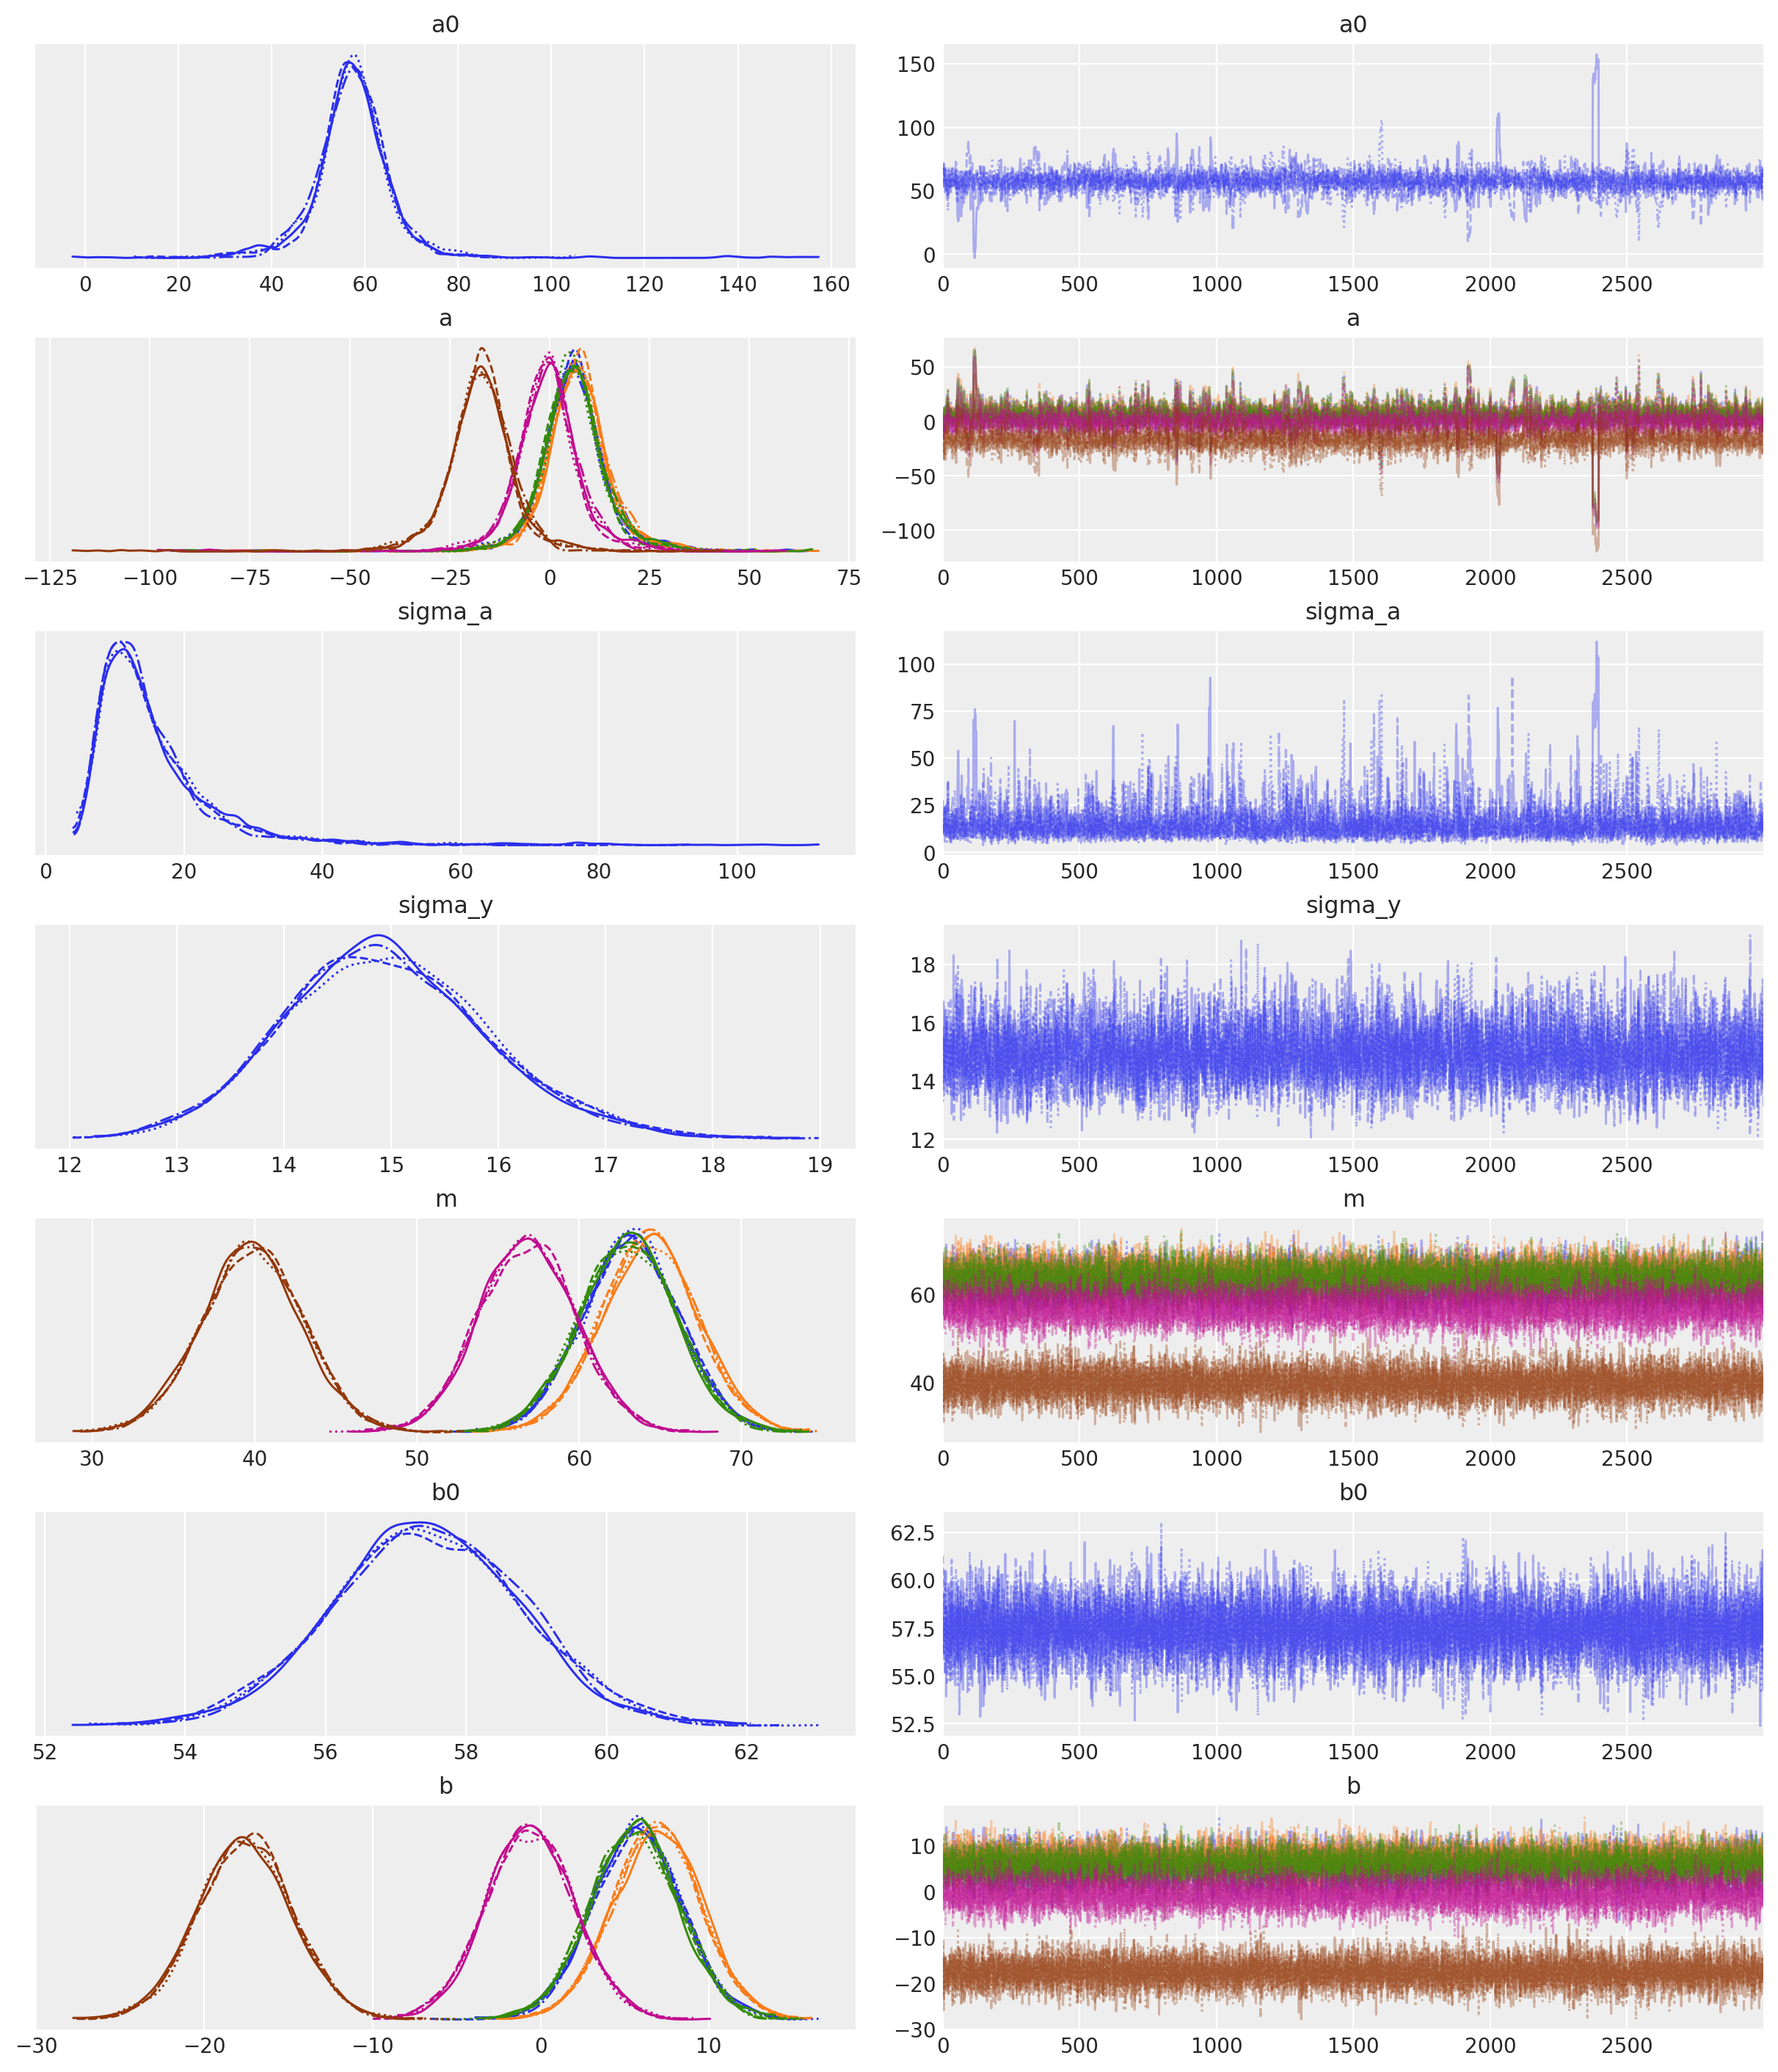

In [8]:
az.plot_trace(idata);

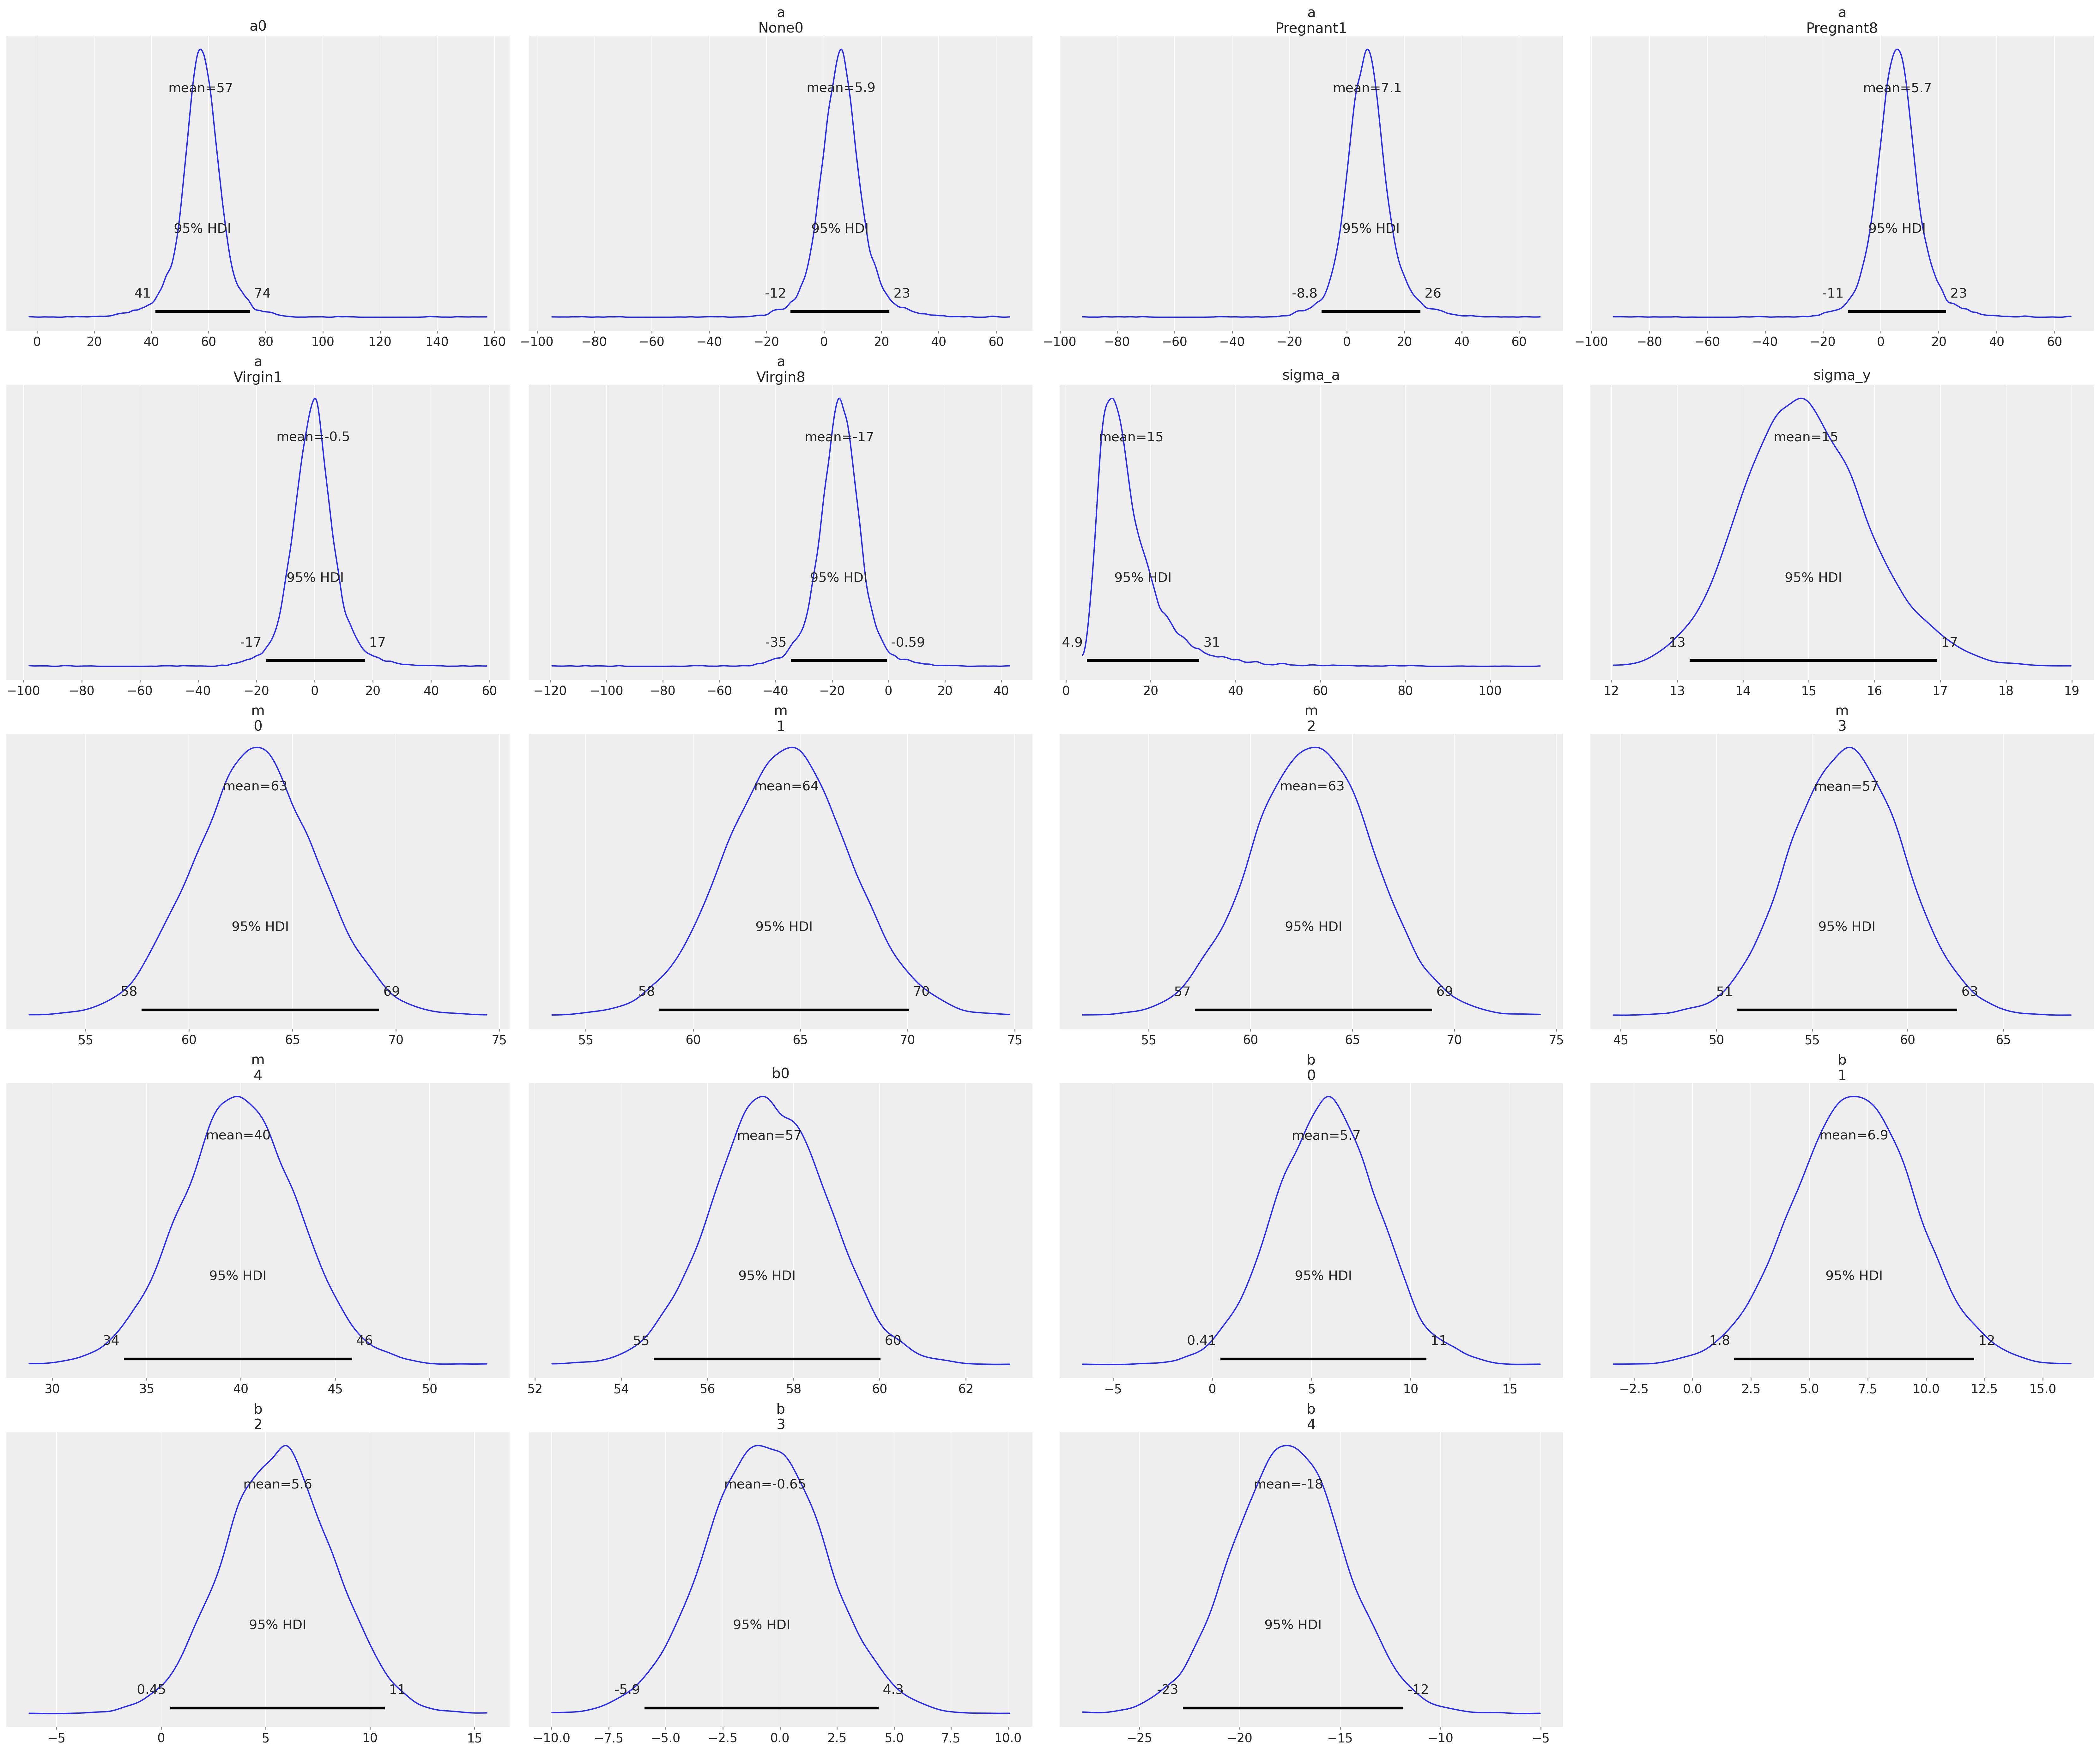

In [9]:
az.plot_posterior(idata);

In [13]:
post = az.extract(idata.posterior)
post

<xarray.Dataset>
Dimensions:  (sample: 12000, groups: 5, m_dim_0: 5, b_dim_0: 5)
Coordinates:
  * groups   (groups) <U9 'None0' 'Pregnant1' 'Pregnant8' 'Virgin1' 'Virgin8'
  * m_dim_0  (m_dim_0) int64 0 1 2 3 4
  * b_dim_0  (b_dim_0) int64 0 1 2 3 4
  * sample   (sample) object MultiIndex
  * chain    (sample) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3 3
  * draw     (sample) int64 0 1 2 3 4 5 6 ... 2993 2994 2995 2996 2997 2998 2999
Data variables:
    a0       (sample) float64 53.71 56.64 57.3 71.76 ... 54.81 56.67 61.24 61.36
    a        (groups, sample) float64 5.141 10.77 5.087 ... -18.96 -20.02 -23.23
    sigma_a  (sample) float64 9.494 9.391 11.1 21.79 ... 11.84 11.8 14.82 12.82
    sigma_y  (sample) float64 15.72 15.85 14.62 15.01 ... 13.89 14.48 13.14
    m        (m_dim_0, sample) float64 58.85 67.41 62.39 ... 37.71 41.22 38.12
    b0       (sample) float64 55.85 59.13 59.02 59.26 ... 57.06 57.63 58.19
    b        (b_dim_0, sample) float64 3.002 8.285 3.369 ... -16.42 -20.07
Attributes:
    created_at:                 2022-11-18T21:26:11.186459
    arviz_version:              0.13.0
    inference_library:          pymc
    inference_library_version:  4.3.0
    sampling_time:              38.688457012176514
    tuning_steps:               1000

### Contrasts

Below, I'm taking advantage of the label-based indexing functionality afforded by Xarray.dataset objects. See [here](https://docs.xarray.dev/en/stable/getting-started-guide/quick-overview.html) for a quick overview on working with the xarray library. 

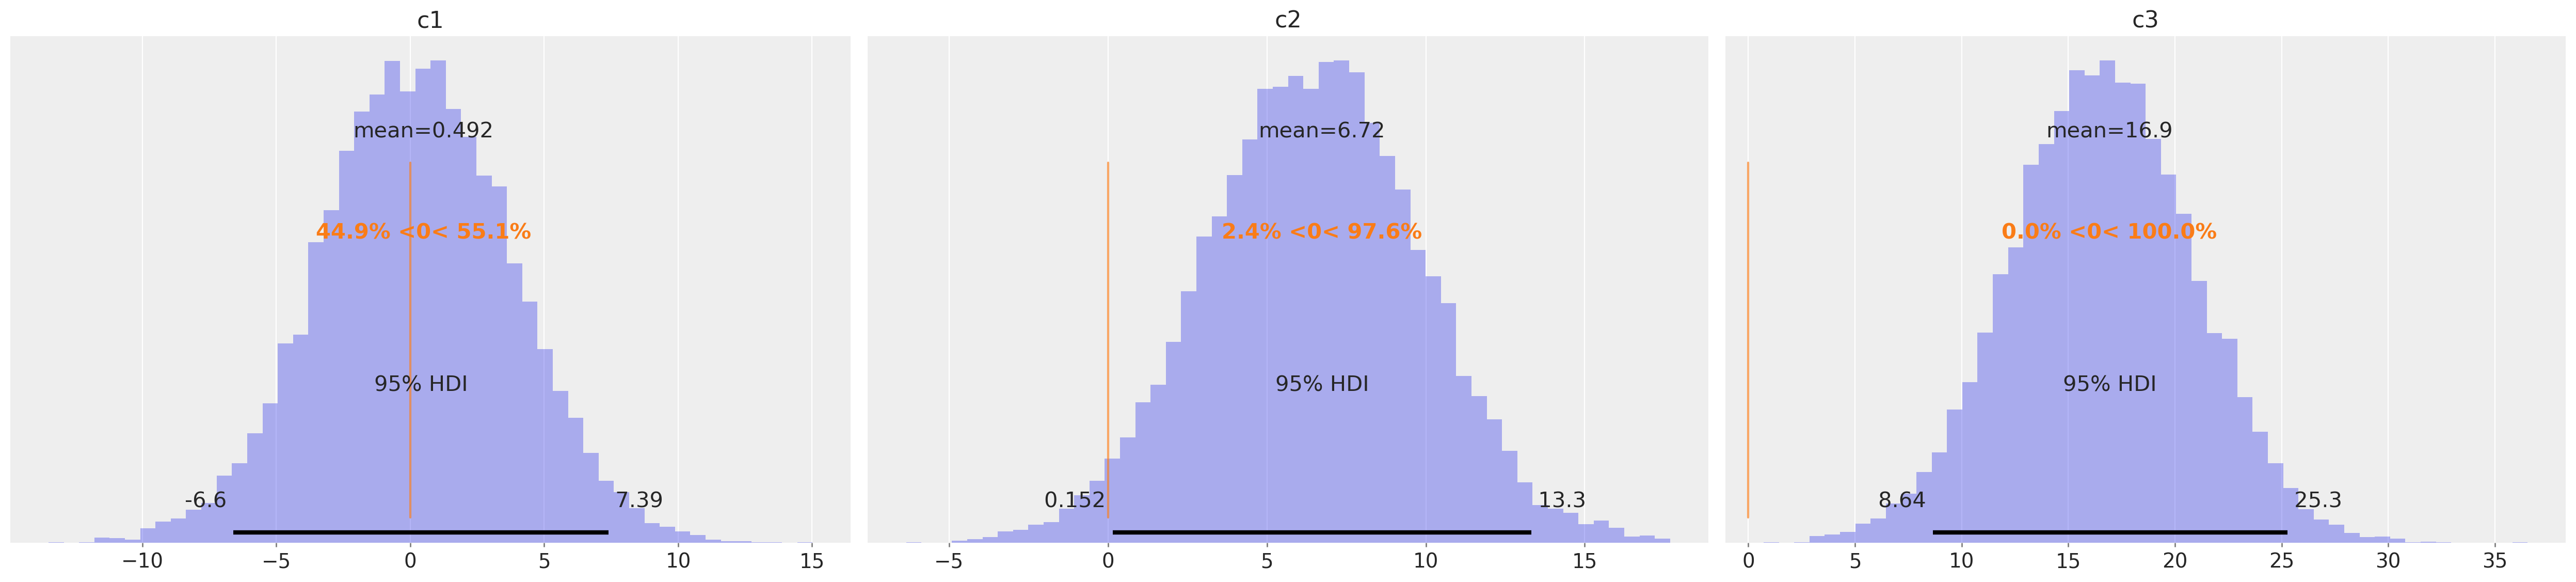

In [12]:
contrasts = dict(c1=(post.a.sel(groups=["Pregnant1", "Pregnant8"]).mean(axis=0) - post.a.sel(groups="None0")).values,
             c2=(post.a.sel(groups=["Pregnant1", "Pregnant8", "None0"]).mean(axis=0) - post.a.sel(groups="Virgin1")).values,
             c3=(post.a.sel(groups=["Virgin1"]).values - post.a.sel(groups=["Virgin8"]).values).flatten())

az.plot_posterior(contrasts, kind="hist", round_to=3, ref_val=0, bins=50);

### ANCOVA

In [ ]:
y = df.Longevity
mu_y = y.mean()
sigma_y = y.std()
x_nom = df.CompanionNumber
x_met = df.Thorax
mu_x_met = x_met.mean()
sigma_x_met = x_met.std()

In [ ]:
model2, idata2 = bst.metric_outcome_one_nominal_one_metric_predictor(x, x_met, y, mu_x_met, mu_y, sigma_x_met, sigma_y)

In [ ]:
stacked2 = az.extract(idata2.posterior)
contrasts2 = {"Pregnant1Pregnant8 vs None0": 
              (stacked2.a.sel(groups=["Pregnant1", "Pregnant8"]).mean(axis=0) - stacked2.a.sel(groups="None0")).values,
              "Pregnant1Pregnant8None0 vs Virgin1":
              (stacked2.a.sel(groups=["Pregnant1", "Pregnant8", "None0"]).mean(axis=0) - stacked2.a.sel(groups="Virgin1")).values,
             "Virgin1 vs Virgin8":
              (stacked2.a.sel(groups=["Virgin1"]).values - stacked2.a.sel(groups=["Virgin8"]).values).flatten()}

In [ ]:
az.plot_posterior(contrasts2, kind="hist", round_to=3, ref_val=0);

### Robust ANOVA with Heterogeneous Variances 

In [ ]:
df2 = pd.read_csv('../kruschke_data/NonhomogVarData.csv')  # Not including the dtype argument to make sure my function works
df2.info()


In [ ]:
df2.groupby('Group').head(3)

In [ ]:
y = df2.Y
x = df2.Group
# xlevels = df2.Group.cat.categories
# NxLvl = len(xlevels) 
mu_y = y.mean()
sigma_y = y.std()

In [ ]:
model3, idata3 = bst.robust_anova(x, y, mu_y, sigma_y, n_draws=2000)

In [ ]:
az.plot_trace(idata3);